In [13]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('fifi_cleaned.csv', parse_dates=True)

In [14]:
# NOTE: Convert thi back to hourly

df['Created Date'] = pd.to_datetime(df['Created Date'])

df['Created Date'] = df['Created Date'].dt.date

In [15]:
df['Created Date'].head()

0    2013-05-09
1    2013-08-13
2    2013-08-13
3    2013-08-13
4    2013-08-14
Name: Created Date, dtype: object

In [16]:
df.set_index('Created Date', inplace=True)
df.index.freq = 'D'

In [17]:
df.head()

,Unnamed: 0,Service Request Number,Location,Location Details,Description,Category,location_latitude,location_longitude,location_X,location_Y,zipcode
Created Date,,,,,,,,,,,
2013-05-09,0,13-00036779,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,Abandoned Vehicle,47.555513,-122.302999,1277537.1732614825,206078.498081425,98108.0
2013-08-13,1,13-00064098,"2629 SW ANDOVER ST, SEATTLE, WA","26012799 SW Andover St, Seattle; XY: 1261975.9...",NaN,Abandoned Vehicle,47.568284,-122.366419,1261975.9119158287,211063.7734459653,98106.0
2013-08-13,2,13-00064109,"402 BELMONT AVE E, SEATTLE, WA","327 Belmont Ave E, Seattle; XY: 1272796.132329...",I don't think this car has been moved in quite...,Abandoned Vehicle,47.621621,-122.324114,1272796.1323291115,230309.9327528307,98102.0
2013-08-13,3,13-00064128,"5283 39TH AVE S, SEATTLE, WA","5239 39th Ave S Seattle, WA 98118; XY: 1282330...",Older Honda with flat tire,Abandoned Vehicle,47.554657,-122.284155,1282330.8128522313,205697.9753960121,98118.0
2013-08-14,4,13-00064164,"4755 38TH AVE SW, SEATTLE, WA","XY: 1258575.3814046786, 207971.16513023284; La...",Green 4 door Volkswagen Golf,Abandoned Vehicle,47.559633,-122.379917,1258575.3814046786,207971.16513023284,98126.0


In [18]:
df['Category'].unique()  # ['Service Request Number'].cumsum()

array(['Abandoned Vehicle', 'Clogged Storm Drain', 'Community Walk',
       'Dead Animal', 'Graffiti Report', 'Litter-Illegal Dumping-Needles',
       'Other Inquiry', 'Overgrown Vegetation', 'Parking Enforcement',
       'Pothole', 'Sign and Signal Maintenance', 'Streetlight Report'],
      dtype=object)

In [19]:
needles_dumping_df = df[df['Category'] == 'Litter-Illegal Dumping-Needles']

In [20]:
needles_dumping_df.head()

,Unnamed: 0,Service Request Number,Location,Location Details,Description,Category,location_latitude,location_longitude,location_X,location_Y,zipcode
Created Date,,,,,,,,,,,
2014-04-05,71418,14-00033972,"2909 W COMMODORE WAY, SEATTLE, WA","2800 W Commodore Way, Seattle; XY: 1255733.746...",NaN,Litter-Illegal Dumping-Needles,47.662873,-122.394547,1.25573e+06,245649,98199.0
2014-04-05,71419,14-00033973,"6711 42ND AVE S, SEATTLE, WA","6600-6698 42nd Ave S, Seattle; XY: 1282955.294...",NaN,Litter-Illegal Dumping-Needles,47.542588,-122.280735,1.28296e+06,201284,98118.0
2014-04-05,71420,14-00033998,"2820 E SPRING ST, SEATTLE, WA","2801-2899 E Spring St, Seattle; XY: 1279672.76...",NaN,Litter-Illegal Dumping-Needles,47.611687,-122.295948,1.27967e+06,226573,98122.0
2014-04-07,71421,14-00034568,"422 4TH AVE, SEATTLE, WA","441-483 4th Ave, Seattle; XY: 1271362.91443646...",NaN,Litter-Illegal Dumping-Needles,47.602108,-122.329362,1.27136e+06,223217,98104.0
2014-04-10,71422,14-00036291,"8455 DELRIDGE WAY SW, SEATTLE, WA","8418 Delridge Way SW, Seattle; XY: 1263170.034...",NaN,Litter-Illegal Dumping-Needles,47.527561,-122.359981,1.26317e+06,196183,98106.0


In [80]:
needles_dumping_daily_trend = needles_dumping_df.index.value_counts().sort_index()
needles_dumping_daily_trend.head()

2014-04-05    3
2014-04-07    1
2014-04-10    7
2014-04-11    3
2014-04-12    1
Name: Created Date, dtype: int64

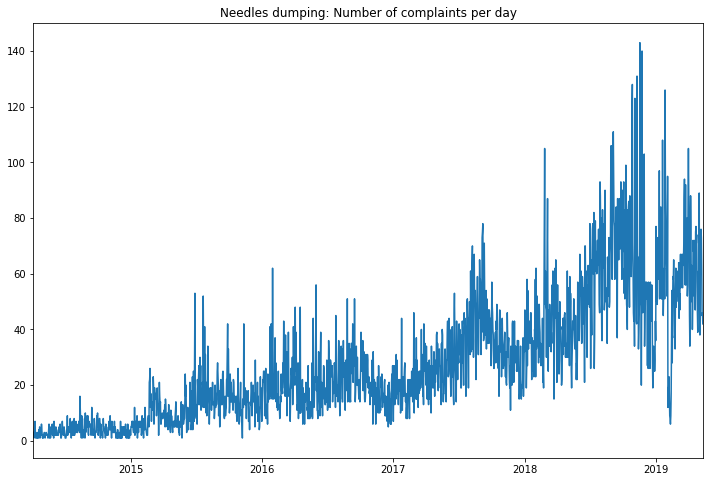

In [81]:
title = 'Needles dumping: Number of complaints per day'

ax = needles_dumping_daily_trend.plot(figsize=(12,8), title=title)
ax.autoscale(axis='x', tight=True)

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [83]:
needles_dumping_compliants = pd.DataFrame(needles_dumping_daily_trend)
needles_dumping_compliants.rename(columns={'Created Date': 'Total complaints'}, inplace=True)
needles_dumping_compliants.head()

,Total complaints
2014-04-05,3
2014-04-07,1
2014-04-10,7
2014-04-11,3
2014-04-12,1


In [84]:
needles_dumping_compliants.index.freq = 'D'

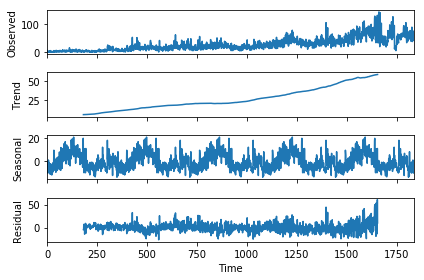

In [86]:
result = seasonal_decompose(needles_dumping_compliants['Total complaints'].values, model='add', freq=365)
result.plot();

In [87]:
needles_dumping_compliants.index

Index([2014-04-05, 2014-04-07, 2014-04-10, 2014-04-11, 2014-04-12, 2014-04-13,
       2014-04-15, 2014-04-16, 2014-04-17, 2014-04-18,
       ...
       2019-05-03, 2019-05-04, 2019-05-05, 2019-05-06, 2019-05-07, 2019-05-08,
       2019-05-09, 2019-05-10, 2019-05-11, 2019-05-12],
      dtype='object', length=1838)

In [88]:
auto_arima(needles_dumping_compliants['Total complaints'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1838
Model:             SARIMAX(1, 1, 1)x(0, 0, 2, 12)   Log Likelihood               -7047.855
Date:                            Sun, 19 Jan 2020   AIC                          14107.711
Time:                                    10:04:28   BIC                          14140.806
Sample:                                         0   HQIC                         14119.915
                                           - 1838                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0236      0.024      1.000      0.317      -0.023       0.070
ar.L1          0.2208      0.017     12.960      0.000       0.187       0.254
ma.L1         -0.9078      0.008   -112.118      0.000      -0.924      -0.892
ma.S.L12      -0.0439      0.016     -2.829      0.005      -0.074      -0.013
ma.S.L24      -0.0569      0.017     -3.422      0.001      -0.090      -0.024
sigma2       125.7819      2.137     58.863      0.000     121.594     129.970
===================================================================================
Ljung-Box (Q):                      321.71   Jarque-Bera (JB):              4774.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.81   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
len(needles_dumping_compliants)

1838

In [90]:
train = needles_dumping_compliants.iloc[:1658]
test = needles_dumping_compliants.iloc[1658:]

In [93]:
model = SARIMAX(train['Total complaints'],order=(1, 2, 2), seasonal_order=(0, 0, 2, 12), enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                   Total complaints   No. Observations:                 1658
Model:             SARIMAX(1, 2, 2)x(0, 0, 2, 12)   Log Likelihood               -6129.119
Date:                            Sun, 19 Jan 2020   AIC                          12270.238
Time:                                    10:06:35   BIC                          12302.711
Sample:                                         0   HQIC                         12282.275
                                           - 1658                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1977      0.017     11.376      0.000       0.164       0.232
ma.L1         -1.9253      0.011   -182.728      0.000      -1.946      -1.905
ma.L2          0.9252      0.010     88.388      0.000       0.905       0.946
ma.S.L12      -0.0943      0.021     -4.571      0.000      -0.135      -0.054
ma.S.L24      -0.0420      0.019     -2.162      0.031      -0.080      -0.004
sigma2        95.0061      1.947     48.793      0.000      91.190      98.822
===================================================================================
Ljung-Box (Q):                      396.28   Jarque-Bera (JB):              2967.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.35   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, index=test.index).rename('SARIMA(1, 2, 2)(0, 0, 2, 12) Predictions')

In [108]:
# Plot predictions against known values
# title = 'Needles dumping: Number of complaints per day'

# test['Total complaints'].plot(legend=True,figsize=(12,6),title=title)
# predictions.plot(legend=True)

predictions.head()

2018-11-14    72.612302
2018-11-15    76.899595
2018-11-16    68.504309
2018-11-17    70.255795
2018-11-18    71.587273
Name: SARIMA(1, 2, 2)(0, 0, 2, 12) Predictions, dtype: float64

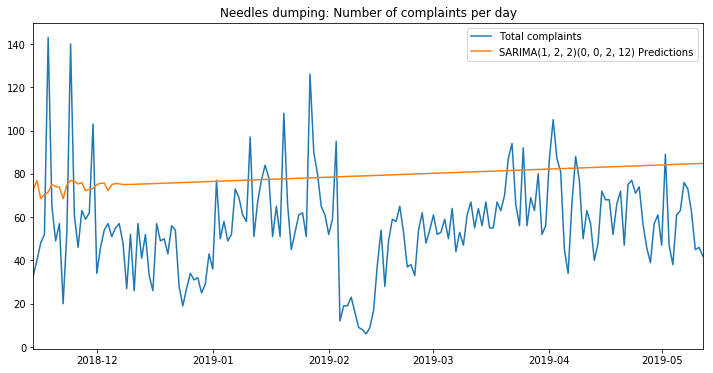

In [109]:
# Plot predictions against known values
title = 'Needles dumping: Number of complaints per day'

ax = test['Total complaints'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True);

TypeError: index type not supported

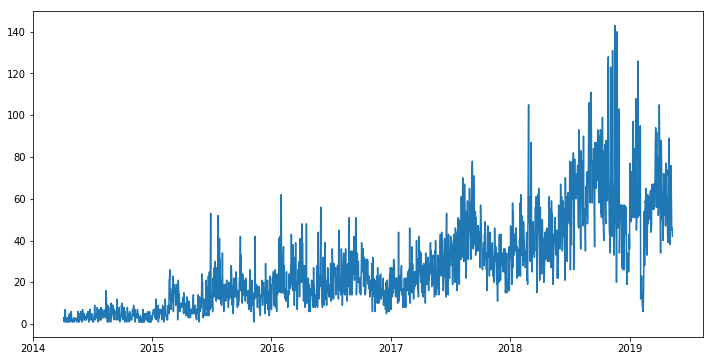

In [112]:
model = SARIMAX(needles_dumping_compliants['Total complaints'],order=(1, 2, 2), seasonal_order=(0, 0, 2, 12), enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(df),len(df)+180,typ='levels').rename('SARIMA(1, 2, 2)(0, 0, 2, 12) Forecast')

# Plot predictions against known values
title = 'Needles dumping: Number of complaints per day'

ax = needles_dumping_compliants['Total complaints'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')